# Import dependencies

Using `conda` is recommended, but you can use `pip`. First, you may need to install 
* NumPy - `pip install numpy`,
* Matplotlib - `pip install matplotlib`,
* PyTorch - `pip install torch torchvision`.

Second, you need to change the current directory to `neural-ot`. Just run the cell below.

In [ ]:
cd ..

Now you can import all required dependencies.

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.datasets import MNIST, USPS
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.distributions import MultivariateNormal

from neural_ot.data_loading import ZipLoader
from neural_ot.model import NeuralOT, Unflatten, Vector
from neural_ot.train import train

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global variables
First, we set `DEVICE` and `IS_CUDA` global variables.

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:1')
    IS_CUDA = True
else:
    DEVICE = torch.device('cpu')
    IS_CUDA = False

Second, we download MNIST and USPS datasets using `torchvision.datasets`. We normalize intensities from the default interval $[0, 1]$ to the interval $[-1, 1]$ via linear transformation $I' = (I - 0.5) / 0.5$ (as it was done in the original paper). Also for the generative modeling task we concatenate train and test sets to the single dataset, held in global variable `mnist`. The same is done with `usps`.

In [5]:
h, w = 16, 16
mnist_tr = transforms.Compose([transforms.Resize((h, w)),
                               transforms.ToTensor(), 
                               transforms.Normalize([.5], [.5]),
                               ])
usps_tr  = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize([.5], [.5]),
                               ])

In [6]:
mnist_train = MNIST('data/mnist', download=True, transform=mnist_tr, train=True)
mnist_test = MNIST('data/mnist', download=True, transform=mnist_tr, train=False)
mnist = ConcatDataset([mnist_train, mnist_test])

usps_train = USPS('data/usps', download=True, transform=usps_tr, train=True)
usps_test = USPS('data/usps', download=True, transform=usps_tr, train=False)
usps = ConcatDataset([usps_train, usps_test])

In [7]:
BATCH_SIZE = 300
N_BATCHES_PER_EPOCH = 10
N_WORKERS = 4

In [8]:
paired_loader = ZipLoader(mnist, usps, batch_size=BATCH_SIZE, n_batches=N_BATCHES_PER_EPOCH, 
                          pin_memory=IS_CUDA, return_idx=True, num_workers=N_WORKERS)

In [9]:
for (x_idx, x), (y_idx, y) in paired_loader:
    print(x_idx.shape, x.shape, y_idx.shape, y.shape)
    break

torch.Size([300]) torch.Size([300, 1, 16, 16]) torch.Size([300]) torch.Size([300, 1, 16, 16])


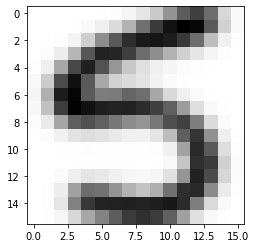

In [10]:
plt.imshow(y[0, 0].numpy(), cmap="Greys")

We parametrized the $u$ and $v$ functions as neural networks as they provided better performance in our setting. Nevertheless, one can use `Vector` class to treat $u$ and $v$ as vectors. In this case don't forget to uncomment corresponding lines.

In [ ]:
source_dual_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(h * w, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1),
    nn.Flatten(start_dim=0)
)
# source_dual_net = Vector(initial=1e-2 * torch.randn(len(mnist)))

target_dual_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(h * w, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1),
    nn.Flatten(start_dim=0)
)
# source_dual_net = Vector(initial=1e-2 * torch.randn(len(usps)))

source_to_target_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(h * w, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, h * w),
    Unflatten(h, w),
    nn.Tanh()
)

In [12]:
# ot = torch.load('generative_model.pth')
ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
              regularization_mode='l2', regularization_parameter=0.05, 
              from_discrete=False, to_discrete=False).to(DEVICE)

## In the case we use vectors, we are working in the discrete setting
# ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
#               regularization_mode='l2', regularization_parameter=0.05, 
#               from_discrete=True, to_discrete=True).to(DEVICE)

In [13]:
plan_optimizer = Adam(ot.parameters(), lr=1e-3)
plan_scheduler = MultiStepLR(plan_optimizer, [20, 75])

# # The training procedure is changed too
# plan_optimizer = Adam(ot.parameters(), lr=1.)
# plan_scheduler = MultiStepLR(plan_optimizer, [100, 400, 800])

In [14]:
losses = train(ot.plan_criterion, plan_optimizer, paired_loader, n_epochs=1000, device=DEVICE, 
               scheduler=plan_scheduler)

100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]


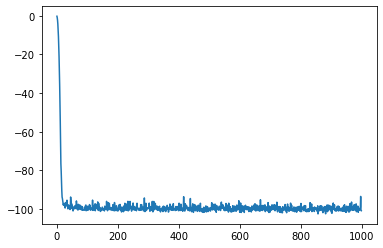

In [15]:
plt.plot(losses)

In [16]:
mapping_optimizer = Adam(ot.parameters(), lr=1e-4)
mapping_scheduler = None

In [17]:
mapping_losses = train(ot.mapping_criterion, mapping_optimizer, paired_loader, n_epochs=1000, device=DEVICE, 
                       scheduler=mapping_scheduler)

100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]


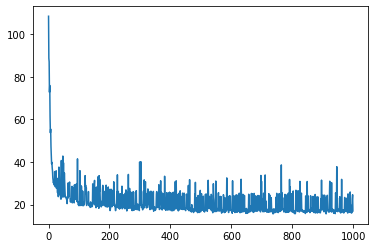

In [18]:
plt.plot(mapping_losses)

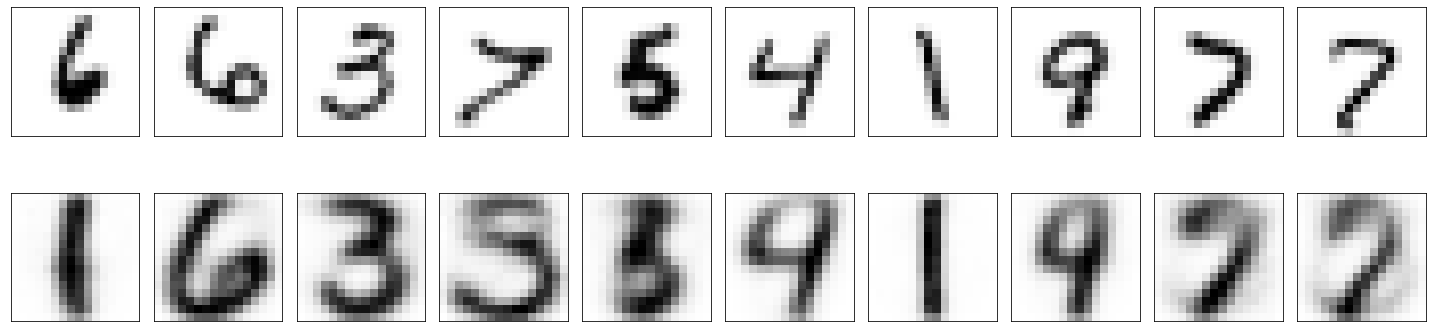

In [19]:
n_samples = 10
idx = torch.multinomial(torch.ones(len(mnist)), n_samples)
ot.eval().cpu()

fig, axes = plt.subplots(2, n_samples, figsize=(20, 6))

for i in range(n_samples):
    img = mnist[idx[i]][0]
    axes[0, i].imshow(img.squeeze(), cmap="Greys")
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    mapped = ot.map(img.reshape(1, 1, h, w))
    axes[1, i].imshow(mapped.squeeze().detach().numpy(), cmap="Greys")
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
plt.tight_layout()
fig.savefig("mappings.png")

In [20]:
X_source, y_source = [], []
for i in tqdm(range(len(mnist)), "MNIST"):
    X, y = mnist[i]
    X_source.append(X)
    y_source.append(y)

X_source = torch.cat(X_source).reshape(-1, h*w).numpy()
y_source = np.array(y_source)

X_target, y_target = [], []
for i in tqdm(range(len(usps)), "USPS"):
    X, y = usps[i]
    X_target.append(X)
    y_target.append(y)

X_target = torch.cat(X_target).reshape(-1, h*w).numpy()
y_target = np.array(y_target)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier(n_neighbors=1)#, metric="correlation")
clf.fit(X_source, y_source)

y_pred = clf.predict(X_target)
print("1-KNN accuracy: {:.3f}".format(accuracy_score(y_target, y_pred)))

X_source_mapped, y_source_mapped = [], []
for i in tqdm(range(len(mnist)), "MNIST -> USPS"):
    X, y = mnist[i]
    mapped = ot.map(X.reshape(1, 1, h, w))
    X_source_mapped.append(mapped.squeeze())
    y_source_mapped.append(y)

X_source_mapped = torch.cat(X_source_mapped).reshape(-1, h*w).detach().numpy()
y_source_mapped = np.array(y_source_mapped)

clf = KNeighborsClassifier(n_neighbors=1)#, metric="correlation")
clf.fit(X_source_mapped, y_source_mapped)

y_pred = clf.predict(X_target)
print("Mapped 1-KNN accuracy: {:.3f}".format(accuracy_score(y_target, y_pred)))

MNIST -> USPS:   0%|          | 196/70000 [00:00<00:35, 1953.71it/s]

1-KNN accuracy: 0.735


MNIST -> USPS: 100%|██████████| 70000/70000 [00:42<00:00, 1630.36it/s]


Mapped 1-KNN accuracy: 0.608


In [22]:
torch.save(ot, 'adaptation_model.pth')